In [1]:
import numpy as np
from scipy import sparse
import heapq
import matplotlib.pyplot as plt

In [2]:
def generate_quadratic_objective(n, density=0.1, alpha=0.1):
    """
    Generate a quadratic objective function with a sparse positive semi-definite Q.

    :param n: The size of the input vector x.
    :param density: The density of the sparse matrix.
    :return: A function that calculates the value of the objective function and its gradient.
    """
    # Generate a random sparse matrix
    np.random.seed(0)
    A = sparse.random(n, n, density=density)

    # Generate Q as the product of A and its transpose
    Q = A.T @ A

    Q = Q.toarray() + alpha * np.eye(n)

    # Generate a random vector b
    b = np.random.randn(n)

    # Dictionary containing the non-zero elements' indices
    dict_nonzeros = {i: np.nonzero(Q[:, i])[0] for i in range(Q.shape[1])}

    # Define the objective function
    def f(x):
        return 0.5 * x.T @ Q @ x + b.T @ x

    # Define the gradient of the objective function
    def grad_f(x):
        return Q @ x + b

    # Function for fast updates of the objective function
    def fast_updates_f(fx, gx, stepsize, idx):
        list_nonzeros = dict_nonzeros[idx]
        fx = fx - stepsize * gx[idx] ** 2 + 0.5 * stepsize ** 2 * Q[idx, idx] * gx[idx] ** 2
        gx[list_nonzeros] = gx[list_nonzeros] - stepsize * Q[list_nonzeros, idx] * gx[idx]
        return fx, gx, list_nonzeros

    # Function for safe updates of the objective function
    def safe_updates_f(x):
        gx = grad_f(x)
        fx = f(x)
        return fx, gx

    return fast_updates_f, safe_updates_f, Q, b

In [3]:
# stepsize_strategies
def stepsize_creator(stepsize_strat, Q):
    """
    Creates a stepsize strategy function based on the selected strategy and matrix Q.

    :param stepsize_strat: The selected stepsize strategy.
    :param Q: The matrix Q.
    :return: The stepsize strategy function.
    """

    if stepsize_strat == 'L':
        # Calculate the spectral norm of Q
        L = np.linalg.norm(Q, ord=2)
        def stepsize_strat(grad_i, i):
            # Return the stepsize based on the spectral norm
            return 1 / L

    elif stepsize_strat == 'block_L':
        # Calculate the L2 norms of the columns of Q
        vec_norms = np.linalg.norm(Q, ord=2, axis=0)
        def stepsize_strat(grad_i, i):
            # Return the stepsize based on the L2 norm of the corresponding column of Q
            return 1 / vec_norms[i]

    elif stepsize_strat == 'exact':
        # Extract the diagonal of Q
        vec_curvatures = np.diag(Q)
        def stepsize_strat(grad_i, i):
            # Return the stepsize based on the diagonal elements of Q
            return 1 / vec_curvatures[i]

    return stepsize_strat

In [4]:
# priority_strategies
def max_priority_generator(priority_type, Q):
    """
    Generates a function to calculate the priority of an element based on the selected strategy and matrix Q.

    :param priority_type: The selected priority strategy.
    :param Q: The matrix Q.
    :return: The priority function.
    """

    if priority_type == 'abs':
        def abs_val(val, idx):
            # Calculate the absolute value of the element
            return abs(val)
        return abs_val

    elif priority_type == 'abs_L':
        # Calculate the L2 norms of the columns of Q
        vec_norms = np.linalg.norm(Q, ord=2, axis=0)
        def abs_val_scaled(val, idx):
            # Calculate the absolute value of the element scaled by the L2 norm of the corresponding column of Q
            return abs(val) / vec_norms[idx]
        return abs_val_scaled

    elif priority_type == 'max_improvement':
        # Extract the diagonal of Q
        vec_curvatures = np.diag(Q)
        def improvement(val, idx):
            # Calculate the priority based on the improvement of the objective function value
            return val ** 2 / vec_curvatures[idx]

        return improvement

In [5]:
class Heap:
    def __init__(self, gradient, f_priorities):
        # Initialize the heap with priorities calculated from the given function
        self.f_priorities = f_priorities
        self.heap = [(-f_priorities(val, idx), idx) for idx, val in enumerate(gradient)]
        heapq.heapify(self.heap)  # Convert the list into a heap structure
        # Update the heap structure with positive values for priorities
        self.heap = [(-vali[0], vali[1]) for vali in self.heap]
        # Dictionary containing the index of each element in the heap
        self.dict = {vali[1]: i for (i, vali) in enumerate(self.heap)}

    def get_max(self):
        # Return the element with the maximum priority (first element in the heap)
        return self.heap[0]

    def update_priority(self, idx, new_val):
        # Update the priority of an element at the given index with a new value
        new_priority = self.f_priorities(new_val, idx)
        i = self.dict[idx]  # Get the index of the element in the heap
        old_priority, _ = self.heap[i]  # Get the old priority of the element
        self.heap[i] = (new_priority, idx)  # Update the priority with the new value and index
        if new_priority > old_priority:
            # New priority is higher than the old one, sift up
            while i > 0:
                parent_i = (i - 1) // 2  # Calculate the index of the parent node
                if self.heap[parent_i] < self.heap[i]:
                    # Swap the current node with its parent if the priority is higher
                    heap_parent_i = self.heap[parent_i]
                    self.heap[parent_i] = self.heap[i]
                    self.heap[i] = heap_parent_i
                    # Update the dictionary with the new indices
                    self.dict[self.heap[parent_i][1]], self.dict[self.heap[i][1]] = parent_i, i
                    i = parent_i  # Move to the parent node
                else:
                    break  # Exit the loop if the heap property is satisfied
        else:
            # New priority is lower or equal to the old one, sift down
            while True:
                left_child_i = 2 * i + 1  # Calculate the index of the left child node
                right_child_i = 2 * i + 2  # Calculate the index of the right child node

                # Find the index of the child with the maximum priority
                max_child_i = i
                if left_child_i < len(self.heap) and self.heap[left_child_i] > self.heap[max_child_i]:
                    max_child_i = left_child_i
                if right_child_i < len(self.heap) and self.heap[right_child_i] > self.heap[max_child_i]:
                    max_child_i = right_child_i
                if max_child_i == i:
                    break  # Exit the loop if the heap property is satisfied

                # Swap the current node with the maximum child
                heap_max_child_i = self.heap[max_child_i]
                self.heap[max_child_i] =  self.heap[i]
                self.heap[i] = heap_max_child_i
                # Update the dictionary with the new indices
                self.dict[self.heap[max_child_i][1]], self.dict[self.heap[i][1]] = max_child_i, i
                i = max_child_i  # Move to the maximum child node

In [6]:
def BCGD_GS(fast_updates_f, safe_updates_f, x0, num_iters=1000, tol=1e-6, f_priorities=None, stepsize_strat=None):
    """
    Block Coordinate Gradient Descent with Gauss-Southwell updates.

    :param fast_updates_f: Function for fast updates of the objective function.
    :param safe_updates_f: Function for safe updates of the objective function.
    :param x0: Initial solution.
    :param num_iters: Maximum number of iterations.
    :param tol: Tolerance for convergence.
    :param f_priorities: Priority function for heap ordering.
    :param stepsize_strat: Step size strategy function.
    :return: The optimized solution and the history of objective function values.
    """
    # Initialize the solution
    x = x0.copy()
    n = len(x)

    # Create a max heap for storing the gradients
    fx, grad = safe_updates_f(x)
    heap_gradient = Heap(grad, f_priorities)
    f_history = [fx]

    for _ in range(num_iters):
        # Extract the feature with the largest gradient
        max_grad_val, idx = heap_gradient.get_max()

        # Perform a line search along the direction of the largest gradient
        step_size = stepsize_strat(grad[idx], idx)
        x[idx] -= step_size * grad[idx]

        # Update the function information
        fx, grad, list_updated = fast_updates_f(fx, grad, step_size, idx)
        f_history.append(fx)

        # Push the updated gradient components to the heap
        for i in list_updated:
            heap_gradient.update_priority(i, grad[i])

        # Check the convergence criterion
        if abs(max_grad_val) < tol:
            break

    return x, f_history

In [ ]:
# block coordinate Gauss-Southwell for the optimization of a quadratic function
# objective f(x) = 0.5 * x^T Q x + b^T x

n = 1000 # problem dimension
density = 0.1 # density of the matrix A such that Q = A^T A
num_iters = 3000 # max number of iterations

# Generate a quadratic objective function f(x) = 0.5 * x^T Q x + b^T x
# fast_updates = function to update gradient and objective quickly
# safe_updates = function to update gradient and objective safely but more slowly
fast_updates_f,  safe_updates_f, Q, b = generate_quadratic_objective(n, density=density)

# Compute the optimal solution and the optimal objective value
x_optimal = np.linalg.solve(Q, -b)
f_optimal = 0.5 * x_optimal.T @ Q @ x_optimal + b.T @ x_optimal

# Initial guess
np.random.seed(1)
x0 = np.random.randn(n)

# stepsize strategies
# L: Lipschitz constant stepsize
# block_L: block coordinate Lipschitz constant stepsize
# exact: exact linesearch stepsize
vec_stepsize_strats = ['L', 'block_L', 'exact']

# priority strategies
# abs: component with largest absolute value
# abs_L: component with largest absolute value divided by block Lipschitz constant
# max_improvement: component that maximizes the improvement in the objective function with linesearch
vec_priority_strats = ['abs', 'abs_L', 'max_improvement']

# dictionary to store function history for each strategy
dict_f_history = {}
for i in range(len(vec_stepsize_strats)):
    # choose stepsize strategy
    stepsize_strat = vec_stepsize_strats[i]
    # choose priority strategy
    priority = vec_priority_strats[i]
    strategy = stepsize_strat + '+' + priority
    # run gauss-southwell
    x_opt, dict_f_history[strategy] = BCGD_GS(fast_updates_f, safe_updates_f, x0,
                                                f_priorities=max_priority_generator(priority, Q),
                                                stepsize_strat = stepsize_creator(stepsize_strat, Q),
                                                num_iters=num_iters)

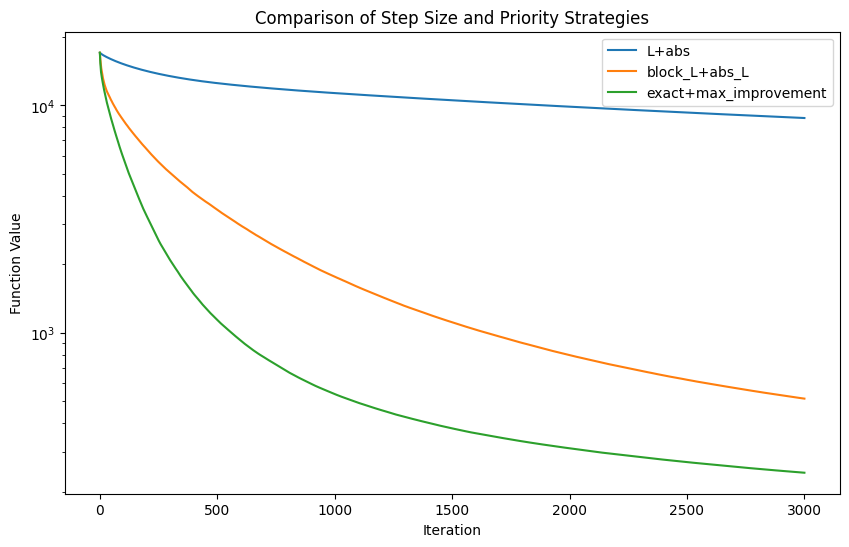

In [8]:
# Start creating the plot
plt.figure(figsize= (10,6))

# plot each strategy
for i in range(len(vec_stepsize_strats)):
    stepsize_strat = vec_stepsize_strats[i]
    priority = vec_priority_strats[i]
    strategy = stepsize_strat + '+' + priority
    # get the function history for the strategy
    f_history = dict_f_history[strategy]
    # Subtract the optimal function value from all function values
    dist_to_optimal = [abs(val - f_optimal) for val in f_history]
    x_values = list(range(len(f_history)))
    plt.semilogy(x_values, dist_to_optimal, label=strategy)

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Function Value')
plt.title('Comparison of Step Size and Priority Strategies')

# Add a legend
plt.legend()

# Show the plot
plt.show()